## JuMP with conic problems


A cone is defined as the subset

````{admonition} Definition: Cone
Vector space $C \subset V$ is a cone if and only if
```{math}
\alpha x \in C, \ \ \forall x \in C, \ \alpha \in \mathbb{R}^+.
```
````

Furthmore, a convex cone

````{admonition} Definition: Convex cone
$C$ is said to be a _convex cone_ if
```{math}
\alpha x + \beta y \in C
```
for any $\alpha, \beta \in \mathbb{R}^+$ and any $x, y \in C$.
````

As an illustrative example, consider the vector space $V$ spanned by $\hat{x}$, $\hat{y}$, $\hat{z}$, with *subspace* $C$ being the plane defined by $x + y + z = 0$.

For any vector $\vec{q} \in C$, the product $\alpha \vec{q} \in C$, thus $C$ is a *cone*, and additionally $\alpha x + \beta y \in C$, as per the above definition, thus $C$ is also a *convex cone*.

This generalizes to the statement that any *subspace* is a *convex cone*.

In linear algebra, the cone definition is extended for a $m \times r$ matrix $A$, the cone is generated by the columns

$$
    C_A = \left\{ Ax \ \vert  \ x \in \mathbb{R}^{r, +} \right\} \subseteq \mathbb{R}^m.
$$

In [22]:
using LinearAlgebra
# reduced set
Rʳ⁺ = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

# 3x4 matrix
A = [-2 -2 -3 -1;
     3  -4 -4  2;
     1  -2  1  3]

Cₐ = [A * x for x in Rʳ⁺]

4-element Vector{Vector{Int64}}:
 [-2, 3, 1]
 [-2, -4, -2]
 [-3, -4, 1]
 [-1, 2, 3]

Plotting these for a visualisation of the cone

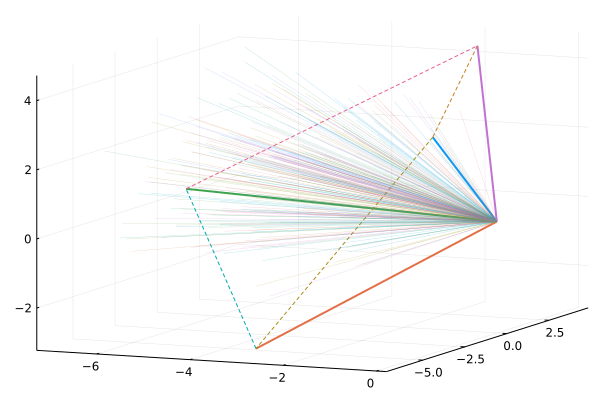

In [23]:
using Plots
gr()
p = plot(legend=false)

plotline!(points; kwargs...) = plot!(points[1,:], points[2,:], points[3,:]; kwargs...)

for v in Cₐ
    points = 1.5 * hcat(zeros(3), v)
    plotline!(points, lw=2)
end

# connect main vertices
for (v1, v2) in zip(Cₐ, [Cₐ[2:end]..., Cₐ[1]])
    points = 1.5 * reduce(hcat, (v1, v2))
    plotline!(points; ls=:dash)
end

# populate some more random v ∈ C
for v in (A * [rand(), rand(), rand(), rand()] for x in 1:300)
    points = hcat(zeros(3), v)
    plotline!(points, lw=0.4, alpha=0.3)
end

p

Note that cones do not have to be circular in the common sense of a cone. Note that since the above $A$ is affine, then $C_A$ is also a *convex cone*.

## Conic programming

A *conic programming* problem is a convex optimization problem; for some convex cone $C \subset V$ and a set of *affine* constraints $h_i(v) = 0, v \in V$ over an *affine* subspace $\mathcal{H}$, the optimization problem is to find
$$
v_0 \in C \cap \mathcal{H},
$$
for which a real-valued convex function $f : C \rightarrow \mathbb{R}$ is minimized.



This is perhaps best explained through an example: consider $C \subset \mathbb{R}^n$

$$
\begin{align}
    & \min_{x \in C} \ \ c^T x, \\
    \text{s.t.} \ \ \ \ \ \ & A x - b = 0, x \in C
\end{align}
$$

Here, our affine transformation is $ x \mapsto A x - b$ giving rise to the constraints on the problem, and our convex function is the product $f : x \mapsto c^T x \in \mathbb{R}$.

Let us consider a few examples in JuMP. Note, as is often the case, the optimization of these problems depends on using the correct solver: see [this table in the documentation](https://jump.dev/JuMP.jl/v0.19.0/installation/index.html#Getting-Solvers-1).

## Example: largest eingenvalue of symmetric matrix

Let $A$ have eigenvalues $\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_n $.

Then the matrix $tI - A$ will have eigenvalues $t - \lambda_1, t - \lambda_2, \dots, t - \lambda_n$. For the case of $t \geq \lambda_1$, all of these eigenvalues will be non-negative.


This problem can then be described by a *Positive Semidefinite Cone*. [Positive semidefinite matrices](http://theanalysisofdata.com/probability/C_4.html) of dimension $n$ form a cone in $\mathbb{R}^n$ denoted by
$$
C_+^n = \left\{ x \in C^n \ \vert \ a^T x a \geq 0, \forall a \in \mathbb{R}^n \right\}
$$

The optimization problem may be written

$$
\begin{align}
    & \lambda_1 = \max t \\
    \text{s.t.} \ \ \ & tI - A \geq 0. \\
\end{align}
$$

In JuMP, this may be expressed:

In [54]:
using JuMP
using SCS # optimizer

A = [3 2 4;
     2 0 2; 
     4 2 3]

model = Model(optimizer_with_attributes(SCS.Optimizer, "verbose" => 0))

@variable(model, t)
@objective(model, Min, t)

@constraint(model, t * Matrix(I, 3, 3) - A in PSDCone())

optimize!(model)

In [55]:
objective_value(model)

7.999999999999894

In [40]:
eigen(A).values

3-element Vector{Float64}:
 -0.9999999999999996
 -0.9999999999999947
  8.0

In [45]:
t * Matrix(I, 3, 3) - A

3×3 Matrix{AffExpr}:
 t - 3  -2  -4
 -2     t   -2
 -4     -2  t - 3